# Model ML HiBeauty!

This notebook presents the machine learning model developed for the Capstone Project of the Bangkit Academy 2024 Batch 1. The model utilizes TensorFlow and various datasets to detect skin diseases. It classifies images into three categories: acne, eye bags, and oily skin. The model is executed on Google Colab.

## Importing Libraries

In [1]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 845.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

In [2]:
import tensorflow as tf
import os
import csv
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/MyDrive/"Capstone Model HiBeauty"/Dataset/"Fix Data"/

Skin_data


## Data Preparation

First, the dataset is loaded and split into training, validation, and testing sets.

### Importing Dataset

In [5]:
# Path to the dataset
dataset_path = '/content/gdrive/MyDrive/Capstone Model HiBeauty/Dataset/Fix Data/Skin_data'

# Category names
categories = ['acne', 'bags', 'oily']

# Output folder path
output_path = './Dataset/Processed_Data'

### Splitting Dataset

In [6]:
# Create output folders
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create sub-folders for training, validation, and testing
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_path, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for category in categories:
        category_path = os.path.join(split_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

# Function to split the dataset
def split_dataset(category):
    category_path = os.path.join(dataset_path, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    return train_images, val_images, test_images

# Move files to appropriate folders
def move_files(images, category, split):
    for image in images:
        src = os.path.join(dataset_path, category, image)
        dst = os.path.join(output_path, split, category, image)
        shutil.copy2(src, dst)

# Split the dataset and move files
for category in categories:
    train_images, val_images, test_images = split_dataset(category)
    move_files(train_images, category, 'train')
    move_files(val_images, category, 'val')
    move_files(test_images, category, 'test')

print("Dataset splitting finished.")

Dataset splitting finished.


## Modelling and Training Data



### Data Generators

In [7]:
# Image data generator with data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Image data generator for validation and test set
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths
train_dir = os.path.join(output_path, 'train')
val_dir = os.path.join(output_path, 'val')
test_dir = os.path.join(output_path, 'test')

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 960 images belonging to 3 classes.
Found 206 images belonging to 3 classes.
Found 208 images belonging to 3 classes.


### Building the Model

In [8]:
# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: acne, bags, oily
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Training the Model

In [9]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

# Save the model
model.save('HiBeauty_3_disease_model.h5')

# Save model architecture and weights to JSON format
model_json = model.to_json()
with open("HiBeauty_3_disease_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("HiBeauty_3_disease_model.weights.h5")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 924ms/step - accuracy: 0.5653 - loss: 0.9909 - val_accuracy: 0.6019 - val_loss: 0.8222 - learning_rate: 0.0010
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 575ms/step - accuracy: 0.8362 - loss: 0.3910 - val_accuracy: 0.6019 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 643ms/step - accuracy: 0.9189 - loss: 0.2508 - val_accuracy: 0.6456 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.9077 - loss: 0.2532 - val_accuracy: 0.6942 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.9427 - loss: 0.1800 - val_accuracy: 0.7718 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 579ms/step - accuracy: 0.9386 - loss: 0.1556 - val_accuracy: 0.7816 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - accuracy: 0.9462 - loss: 0.1471 - val_

### Evaluating the Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8925 - loss: 0.2711
Test accuracy: 0.932692289352417
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step


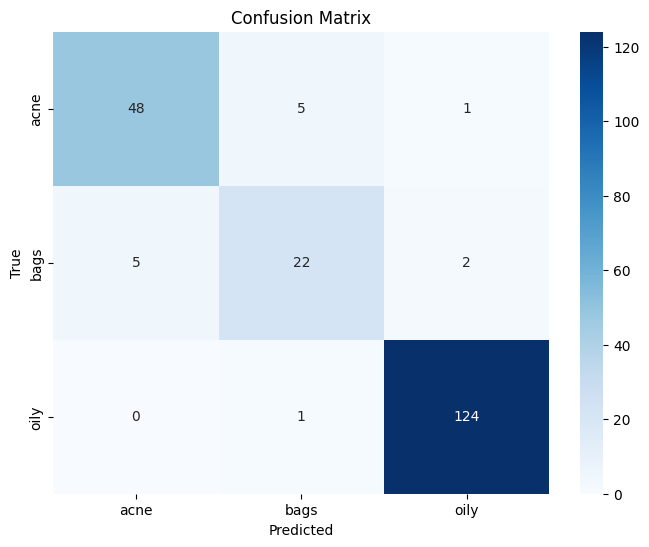

              precision    recall  f1-score   support

        acne       0.91      0.89      0.90        54
        bags       0.79      0.76      0.77        29
        oily       0.98      0.99      0.98       125

    accuracy                           0.93       208
   macro avg       0.89      0.88      0.88       208
weighted avg       0.93      0.93      0.93       208



In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Predict the labels for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=categories))


### Model Conversion

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('HiBeauty_3_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format=keras /content/gdrive/MyDrive/HiBeauty_3_disease_model.h5 /content/gdrive/MyDrive/HiBeauty_3_disease_model


This code provides a clear and structured approach to building and deploying a machine learning model for skin disease classification, making it easier to understand and follow.